In [1]:
import numpy as np
import numpy.matlib
import pickle
import matplotlib.pyplot as plt
import scipy.linalg as sl
import time
import pathlib
import nbimporter  # I installed it for importing an .ipynb file into another .ipynb like the pilot_assignemnt
import os

from datetime import datetime
#import pilot_assignment
#import APLocation_Generation
#import functionRlocalscattering
#------------------------------
#import Power_optimizers



from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import numpy.linalg as l 


import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import math

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
import time
import numpy.linalg as nl 


import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as Kr
from tensorflow.keras import initializers

import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


from __future__ import print_function
import keras
import tensorflow.keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils 

import time

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import mnist

C:\Users\afmb\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\afmb\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:


def uniform_quantization(y, R, b):
    """
    Perform uniform quantization on the vector y with b bits, using a radius R.

    Parameters:
    y (numpy array): The vector to be quantized
    R (float): The radius for quantization
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized vector
    """
    # Number of quantization levels
    L = 2 ** b
    
    # Quantization step size
    delta = 2 * R / (L - 1)
    
    # Quantize the vector
    y_clipped = np.clip(y, -R, R)  # Ensure values are within [-R, R]
    quantized = np.round(y_clipped / delta) * delta
    
    return quantized

def LAQ(x, x_prev, b):
    """
    Quantize the difference between vectors x and x_prev.

    Parameters:
    x (numpy array): Current vector
    x_prev (numpy array): Previous vector
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized difference vector
    """
    # Compute the difference vector
    y = x - x_prev
    
    # Compute the radius R
    R = np.max(np.abs(y))
    
    # Perform uniform quantization
    y_quantized = uniform_quantization(y, R, b)
    err = y_quantized - y
    x_q = y_quantized + x_prev
    return x_q, y_quantized, err

# Example usage
x = np.array([1.2, -0.8, 0.5, -1.0])
x_prev = np.array([1.0, -1.0, 0.4, -0.8])
b = 2  # Number of bits for quantization

# Quantize the difference
x_q, y_quantized, error = LAQ(x, x_prev, b)
print("Quantized + prev:", x_q)
np.max(np.abs(error))

Quantized + prev: [ 1.26666667 -0.73333333  0.53333333 -1.06666667]


0.06666666666666665

In [3]:
x - x_prev

array([ 0.2,  0.2,  0.1, -0.2])

In [1]:
#non-iid
K = 40



# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
num_clients= K


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
# Load CIFAR-10 dataset


#------------------------------DATASETS--------------------------------------------------
## Split the data into non-overlapping portions for each client
client_data = []
samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

# Assume x_train and y_train are numpy arrays, and num_clients is an integer
# Assume x_train and y_train are numpy arrays, and num_clients is an integer
np.random.seed(42)  # For reproducibility

# Shuffle the data to start with a random distribution
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# Group data by class for controlled allocation
class_indices = {}
for label in np.unique(y_train):
    class_indices[label] = list(np.where(y_train == label)[0])  # Convert to list for easy pop operations

# Split data for each client with varying class proportions
client_data = []
num_classes = len(class_indices)
samples_per_client = len(x_train) // num_clients  # Ensures equal samples per client

for i in range(num_clients):
    x_client = []
    y_client = []

    # Determine class proportions for this client
    proportions = np.random.dirichlet(alpha=[0.4] * num_classes)

    # Track the number of samples allocated to this client
    allocated_samples = 0

    while allocated_samples < samples_per_client:
        for label in range(num_classes):
            # Calculate how many samples to take for this class based on proportions
            num_samples = int(proportions[label] * samples_per_client)

            # Adjust to ensure we fill the client's quota exactly
            if allocated_samples + num_samples > samples_per_client:
                num_samples = samples_per_client - allocated_samples

            # Ensure we don't sample more than available for the class
            num_samples = min(num_samples, len(class_indices[label]))

            # Select the samples and add them to the client's data
            class_samples = class_indices[label][:num_samples]
            x_client.extend(x_train[class_samples])
            y_client.extend(y_train[class_samples])

            # Remove used samples from class
            class_indices[label] = class_indices[label][num_samples:]

            # Update allocated sample count
            allocated_samples += len(class_samples)

            # If the client has enough samples, break the loop
            if allocated_samples >= samples_per_client:
                break

    # Shuffle the client's data to randomize order
    x_client = np.array(x_client)
    y_client = np.array(y_client)
    client_indices = np.arange(len(x_client))
    np.random.shuffle(client_indices)
    x_client = x_client[client_indices]
    y_client = y_client[client_indices]

    client_data.append((x_client, y_client))
# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

# client_data now contains non-IID datasets for each client

# Display some information about the distribution
for i, (data, labels) in enumerate(client_data):
    print(f"Client {i}: {len(data)} samples")
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")

# Plot distribution for a few clients
def plot_client_data_distribution(client_data, client_labels, num_clients, num_samples=5):
    """
    Plot sample images from each client's dataset to visualize the distribution.
    
    :param client_data: List of data arrays for each client.
    :param client_labels: List of label arrays for each client.
    :param num_clients: Number of clients to visualize.
    :param num_samples: Number of samples to display per client.
    """
    plt.figure(figsize=(15, 3 * num_clients))
    
    for client_id in range(num_clients):
        data = client_data[client_id]
        labels = client_labels[client_id]
        
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_id * num_samples + i + 1)
            plt.imshow(data[i])
            plt.title(f"Client {client_id}, Label: {labels[i][0]}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
#----------------------------------------------------------------------------------------------

NameError: name 'cifar10' is not defined

In [8]:
# Define neural network architecture
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    return model
# Define the number of clients and local epochs
num_clients= K
#local_epochs = 1
local_epochs0 = 5 #local_epochs FedAvg
local_epochs = 5
epoch_increase = 0
b_j = 10
# Federated Averaging algorithm
num_global_iterations = 50
k_0 = -100 #num_global_iterations +1

learning_rate = 1e-3
optimizer = SGD(learning_rate=learning_rate)
#optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1)

#optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4) #


## Split the data into non-overlapping portions for each client
#client_data = []
#samples_per_client = len(x_train) // num_clients
#for i in range(num_clients):
#    start = i * samples_per_client
#    end = (i + 1) * samples_per_client
#    x_client = x_train[start:end]
#    y_client = y_train[start:end]
#    client_data.append((x_client, y_client))

    
    
##Lambda0 = np.random.rand(num_clients)
#Lambda0 = np.abs(np.random.randn(num_clients))
#LAmbda = np.zeros(num_clients)

#for i in range(num_clients):
#    LAmbda[i] = (1 - Lambda0[i]/np.max(Lambda0) + 0.001)
#Lambda = LAmbda/np.sum(LAmbda)
print('Lambda:', Lambda)
#print('sum lambda:', np.sum(Lambda))
# Initialize the global model
global_model = create_model()


# Compile the global model
global_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
#global_model_FedAvg = global_model 
global_model_FedAvg = create_model()
global_model_FedAvg.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
global_weights = global_model.get_weights()
B_q = np.zeros([8,num_global_iterations])

#------------- FedAvg benchmark----------------------


global_model_FedAvg.set_weights(global_weights)
global_acc_list = []
global_loss_list = []

global_acc_list_FedAvg = []
global_loss_list_FedAvg = []

#----------- Initial values:
initial_loss, initial_accuracy = global_model.evaluate(x_test, y_test)
print(f'Initial Test Loss: {initial_loss:.4f}')
print(f'Initial Test Accuracy: {initial_accuracy:.4f}')

global_acc_list_FedAvg.append(initial_accuracy)
global_acc_list.append(initial_accuracy)

Lambda: <class 'tensorflow.python.keras.layers.core.Lambda'>
313/313 [==============================] - 3s 7ms/step - loss: 2.3062 - accuracy: 0.0965
Initial Test Loss: 2.3054
Initial Test Accuracy: 0.1010


Global Iteration 1/50
Client 1/40


C:\Users\afmb\AppData\Local\Temp\ipykernel_14608\3292832729.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diff_local_global_weight = np.array(local_model.get_weights())#-np.array(global_weights)


max: 0.2828846573829651 ----min: -0.2882973849773407
max error: 0.00028181562558876605
Client 2/40
max: 0.28273507952690125 ----min: -0.2865346372127533
max error: 0.00028009250949434517
Client 3/40
max: 0.28404882550239563 ----min: -0.29038169980049133
max error: 0.0002838530789838756
Client 4/40
max: 0.28280696272850037 ----min: -0.28897905349731445
max error: 0.0002824819682280544
Client 5/40
max: 0.28272849321365356 ----min: -0.28677070140838623
max error: 0.00028032326628385507
Client 6/40
max: 0.2827799916267395 ----min: -0.2930111587047577
max error: 0.00028642342004375765
Client 7/40
max: 0.28311944007873535 ----min: -0.28861984610557556
max error: 0.00028213083685785234
Client 8/40
max: 0.2827288508415222 ----min: -0.28450140357017517
max error: 0.0002781049888271325
Client 9/40
max: 0.2827208638191223 ----min: -0.2847230136394501
max error: 0.00027832161646085263
Client 10/40
max: 0.2862780690193176 ----min: -0.2875923216342926
max error: 0.0002811264141097669
Client 11/40
ma

max: 0.2836771607398987 ----min: -0.28924360871315
max error: 1.0442943094888038e-05
Client 38/40
max: 0.283722847700119 ----min: -0.2874615788459778
max error: 1.0472168684275834e-05
Client 39/40
max: 0.2849608063697815 ----min: -0.2872706949710846
max error: 1.0757392330910942e-05
Client 40/40
max: 0.29492998123168945 ----min: -0.287815660238266
max error: 1.0447328214951979e-05
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.2630 - accuracy: 0.1494
Global Test loss: 2.2630, Global Test accuracy: 0.1494
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.2597 - accuracy: 0.1530
_FedAvg Global Test loss: 2.2597, _FedAvg Global Test accuracy: 0.1530
------------------------------------------------------------------------------------------------------
Glob

max: 0.28770577907562256 ----min: -0.29065242409706116
max error: 6.203968695894964e-06
Client 28/40
max: 0.28378427028656006 ----min: -0.2882053852081299
max error: 6.005188344538649e-06
Client 29/40
max: 0.285807341337204 ----min: -0.286366730928421
max error: 6.687844817820747e-06
Client 30/40
max: 0.28730860352516174 ----min: -0.2923927307128906
max error: 6.407764105138478e-06
Client 31/40
max: 0.28531840443611145 ----min: -0.2925014793872833
max error: 6.586608757261012e-06
Client 32/40
max: 0.2875613570213318 ----min: -0.29179659485816956
max error: 5.7954348265422395e-06
Client 33/40
max: 0.28928783535957336 ----min: -0.28935152292251587
max error: 6.850536712242443e-06
Client 34/40
max: 0.28560706973075867 ----min: -0.29054880142211914
max error: 5.462957073762605e-06
Client 35/40
max: 0.29352444410324097 ----min: -0.2895420491695404
max error: 6.338591322178552e-06
Client 36/40
max: 0.28862956166267395 ----min: -0.2899879813194275
max error: 6.670884387354435e-06
Client 37/40

max: 0.2878987193107605 ----min: -0.29182732105255127
max error: 5.118664768479983e-06
Client 18/40
max: 0.2855682969093323 ----min: -0.2873730957508087
max error: 6.474753507260296e-06
Client 19/40
max: 0.2924209535121918 ----min: -0.29218366742134094
max error: 4.664930023211798e-06
Client 20/40
max: 0.28661617636680603 ----min: -0.2906286120414734
max error: 5.2240818141586e-06
Client 21/40
max: 0.2855066955089569 ----min: -0.28765544295310974
max error: 6.468839989052198e-06
Client 22/40
max: 0.2845747470855713 ----min: -0.28994056582450867
max error: 4.941428079144675e-06
Client 23/40
max: 0.2853858768939972 ----min: -0.29153910279273987
max error: 6.268591103651515e-06
Client 24/40
max: 0.2849263548851013 ----min: -0.2881035804748535
max error: 5.913876782676596e-06
Client 25/40
max: 0.2868972420692444 ----min: -0.28992557525634766
max error: 5.356491257902177e-06
Client 26/40
max: 0.28868722915649414 ----min: -0.2882196307182312
max error: 4.972574807074123e-06
Client 27/40
max:

max: 0.2870677709579468 ----min: -0.29257598519325256
max error: 5.682538425957374e-06
Client 8/40
max: 0.28840696811676025 ----min: -0.2922210991382599
max error: 6.385706068288283e-06
Client 9/40
max: 0.290077805519104 ----min: -0.2927814722061157
max error: 4.467438946501728e-06
Client 10/40
max: 0.2920270264148712 ----min: -0.2889188826084137
max error: 5.002119083552525e-06
Client 11/40
max: 0.2916257679462433 ----min: -0.2877998948097229
max error: 7.651042323935167e-06
Client 12/40
max: 0.2870413661003113 ----min: -0.29160258173942566
max error: 5.336656748597228e-06
Client 13/40
max: 0.2884719669818878 ----min: -0.2899401783943176
max error: 5.6808457938976875e-06
Client 14/40
max: 0.28917181491851807 ----min: -0.2933047413825989
max error: 5.858239013833977e-06
Client 15/40
max: 0.28797447681427 ----min: -0.2908781170845032
max error: 5.3301420812057465e-06
Client 16/40
max: 0.28706201910972595 ----min: -0.29195961356163025
max error: 4.0985102686338926e-06
Client 17/40
max: 0

313/313 [==============================] - 2s 5ms/step - loss: 2.1041 - accuracy: 0.2394
_FedAvg Global Test loss: 2.1041, _FedAvg Global Test accuracy: 0.2394
------------------------------------------------------------------------------------------------------
Global Iteration 10/50
Client 1/40
max: 0.29013893008232117 ----min: -0.2932421565055847
max error: 4.807933451340431e-06
Client 2/40
max: 0.2924498915672302 ----min: -0.29434216022491455
max error: 4.707572929450038e-06
Client 3/40
max: 0.2942471504211426 ----min: -0.2932882606983185
max error: 6.209254771466152e-06
Client 4/40
max: 0.29217883944511414 ----min: -0.2901464104652405
max error: 6.022823748535154e-06
Client 5/40
max: 0.29344508051872253 ----min: -0.2949187755584717
max error: 6.072495194547889e-06
Client 6/40
max: 0.2929593026638031 ----min: -0.29112952947616577
max error: 6.642903156967028e-06
Client 7/40
max: 0.2919495403766632 ----min: -0.2927076518535614
max error: 5.353267915204386e-06
Client 8/40
max: 0.2909

max: 0.2985749840736389 ----min: -0.29382607340812683
max error: 5.5211775481780676e-06
Client 36/40
max: 0.2949243485927582 ----min: -0.2963237166404724
max error: 5.720122686776394e-06
Client 37/40
max: 0.2957371771335602 ----min: -0.2970571517944336
max error: 6.065229179031198e-06
Client 38/40
max: 0.294840544462204 ----min: -0.2966974079608917
max error: 5.898660465348919e-06
Client 39/40
max: 0.2972172498703003 ----min: -0.29616987705230713
max error: 5.275175729642541e-06
Client 40/40
max: 0.2914292514324188 ----min: -0.295833021402359
max error: 5.699496896556522e-06
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.0706 - accuracy: 0.2494
Global Test loss: 2.0706, Global Test accuracy: 0.2494
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.0674

max: 0.2931956946849823 ----min: -0.29381898045539856
max error: 5.377633108034734e-06
Client 26/40
max: 0.29267385601997375 ----min: -0.29524996876716614
max error: 5.110009852121733e-06
Client 27/40
max: 0.29720908403396606 ----min: -0.2915633022785187
max error: 5.325325444919746e-06
Client 28/40
max: 0.296160489320755 ----min: -0.2951076924800873
max error: 5.01639815576882e-06
Client 29/40
max: 0.2985411584377289 ----min: -0.2972643971443176
max error: 3.943760911422588e-06
Client 30/40
max: 0.2987411320209503 ----min: -0.29638639092445374
max error: 4.259971294462775e-06
Client 31/40
max: 0.2921503186225891 ----min: -0.2938326895236969
max error: 5.131363546996559e-06
Client 32/40
max: 0.2939225733280182 ----min: -0.29380232095718384
max error: 5.501017806748901e-06
Client 33/40
max: 0.3001254200935364 ----min: -0.2986171543598175
max error: 5.194468453131353e-06
Client 34/40
max: 0.29336121678352356 ----min: -0.294636994600296
max error: 5.988824055724873e-06
Client 35/40
max: 0

max: 0.2963951826095581 ----min: -0.29638922214508057
max error: 4.8207930628272125e-06
Client 16/40
max: 0.29574862122535706 ----min: -0.29528123140335083
max error: 3.7541597812003336e-06
Client 17/40
max: 0.2982526421546936 ----min: -0.2959403991699219
max error: 3.7664214249080903e-06
Client 18/40
max: 0.29722729325294495 ----min: -0.29319533705711365
max error: 3.54691013233115e-06
Client 19/40
max: 0.2996492385864258 ----min: -0.30015766620635986
max error: 3.367714486631531e-06
Client 20/40
max: 0.29500728845596313 ----min: -0.29784470796585083
max error: 3.7872567298330266e-06
Client 21/40
max: 0.29670706391334534 ----min: -0.2970300614833832
max error: 4.442279867989361e-06
Client 22/40
max: 0.29547998309135437 ----min: -0.29935532808303833
max error: 5.516773985855122e-06
Client 23/40
max: 0.2971051335334778 ----min: -0.30063241720199585
max error: 6.325345314281243e-06
Client 24/40
max: 0.2957651913166046 ----min: -0.2963353097438812
max error: 5.377980958586048e-06
Client 2

max: 0.3009471893310547 ----min: -0.3009241223335266
max error: 4.129271036107905e-06
Client 6/40
max: 0.30044782161712646 ----min: -0.2976321280002594
max error: 3.2582605142884337e-06
Client 7/40
max: 0.30076685547828674 ----min: -0.3000065088272095
max error: 5.210455068678337e-06
Client 8/40
max: 0.29885029792785645 ----min: -0.3005794882774353
max error: 5.070529233500154e-06
Client 9/40
max: 0.30121198296546936 ----min: -0.30104631185531616
max error: 5.064805668902189e-06
Client 10/40
max: 0.30039262771606445 ----min: -0.2975939214229584
max error: 3.3806492013197485e-06
Client 11/40
max: 0.3021923005580902 ----min: -0.2967795729637146
max error: 4.1565440573997775e-06
Client 12/40
max: 0.2970294952392578 ----min: -0.3002159297466278
max error: 5.6442095220845395e-06
Client 13/40
max: 0.29725515842437744 ----min: -0.2996581792831421
max error: 5.461385314712436e-06
Client 14/40
max: 0.2979331612586975 ----min: -0.30125197768211365
max error: 5.071985367342997e-06
Client 15/40
ma

------------------------------------------------------------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.0089 - accuracy: 0.2768
Global Test loss: 2.0089, Global Test accuracy: 0.2768
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 2.0029 - accuracy: 0.2796
_FedAvg Global Test loss: 2.0029, _FedAvg Global Test accuracy: 0.2796
------------------------------------------------------------------------------------------------------
Global Iteration 19/50
Client 1/40
max: 0.2999233603477478 ----min: -0.2996622622013092
max error: 3.874524456526883e-06
Client 2/40
max: 0.30153828859329224 ----min: -0.3021935820579529
max error: 5.501564217658475e-06
Client 3/40
max: 0.30294284224510193 ----min: -0.2988472282886505
max error: 4.340672598629816e-06
Client 4/40
max: 0.30144256353378296 ----min: -0.295522004365921
max 

max: 0.2987675666809082 ----min: -0.30131134390830994
max error: 3.1544115888467762e-06
Client 32/40
max: 0.3002517521381378 ----min: -0.29795441031455994
max error: 3.273112184352337e-06
Client 33/40
max: 0.303863525390625 ----min: -0.3039442002773285
max error: 3.0097130136320753e-06
Client 34/40
max: 0.2997400164604187 ----min: -0.29785022139549255
max error: 3.9634228177504865e-06
Client 35/40
max: 0.30426162481307983 ----min: -0.30137357115745544
max error: 5.9896797069214705e-06
Client 36/40
max: 0.30265289545059204 ----min: -0.30354392528533936
max error: 5.923387166384582e-06
Client 37/40
max: 0.301969438791275 ----min: -0.3042106628417969
max error: 6.398721189824347e-06
Client 38/40
max: 0.3018917441368103 ----min: -0.30374717712402344
max error: 4.6025343874321265e-06
Client 39/40
max: 0.30243876576423645 ----min: -0.3034815788269043
max error: 5.299093200883918e-06
Client 40/40
max: 0.2998993694782257 ----min: -0.30310630798339844
max error: 3.7996449130509903e-06
---------

max: 0.30145496129989624 ----min: -0.3013172149658203
max error: 2.7714962707557633e-06
Client 22/40
max: 0.3005847632884979 ----min: -0.30427294969558716
max error: 3.2604590624206106e-06
Client 23/40
max: 0.30148929357528687 ----min: -0.3053056299686432
max error: 2.939059447646438e-06
Client 24/40
max: 0.3008323013782501 ----min: -0.30154696106910706
max error: 3.7705748247526295e-06
Client 25/40
max: 0.3002109229564667 ----min: -0.302134245634079
max error: 3.091066167742497e-06
Client 26/40
max: 0.30011141300201416 ----min: -0.30342766642570496
max error: 4.198488084211464e-06
Client 27/40
max: 0.30291548371315 ----min: -0.297439306974411
max error: 2.976513749762804e-06
Client 28/40
max: 0.3031983971595764 ----min: -0.3021026849746704
max error: 2.7873675996726785e-06
Client 29/40
max: 0.30389994382858276 ----min: -0.3039948046207428
max error: 3.2749400787515474e-06
Client 30/40
max: 0.3036484718322754 ----min: -0.30309367179870605
max error: 2.464412670013811e-06
Client 31/40
m

max: 0.30537083745002747 ----min: -0.30119389295578003
max error: 2.6869646014581784e-06
Client 12/40
max: 0.3009949028491974 ----min: -0.3048580288887024
max error: 3.998004430874787e-06
Client 13/40
max: 0.301546573638916 ----min: -0.3039218485355377
max error: 2.6733829630934403e-06
Client 14/40
max: 0.3013400733470917 ----min: -0.30570748448371887
max error: 2.956383992097373e-06
Client 15/40
max: 0.3010275661945343 ----min: -0.30312177538871765
max error: 2.56493648844976e-06
Client 16/40
max: 0.3017594814300537 ----min: -0.3023112714290619
max error: 3.0748177829091443e-06
Client 17/40
max: 0.30257248878479004 ----min: -0.3017120361328125
max error: 4.130537666281915e-06
Client 18/40
max: 0.3027258813381195 ----min: -0.30061987042427063
max error: 3.531109112093686e-06
Client 19/40
max: 0.3044187128543854 ----min: -0.3061341941356659
max error: 2.241582258628947e-06
Client 20/40
max: 0.3010433614253998 ----min: -0.3043769299983978
max error: 3.3724493095918864e-06
Client 21/40
ma

max: 0.30330029129981995 ----min: -0.3030983805656433
max error: 3.210177854481161e-06
Client 2/40
max: 0.30613893270492554 ----min: -0.30625417828559875
max error: 3.423663302174265e-06
Client 3/40
max: 0.305967777967453 ----min: -0.30218952894210815
max error: 3.15568456787799e-06
Client 4/40
max: 0.3038580119609833 ----min: -0.3004518151283264
max error: 3.055493390852985e-06
Client 5/40
max: 0.304507315158844 ----min: -0.30634933710098267
max error: 2.97998535464224e-06
Client 6/40
max: 0.30465248227119446 ----min: -0.30252698063850403
max error: 4.588865336890499e-06
Client 7/40
max: 0.3032117784023285 ----min: -0.30571234226226807
max error: 3.726914179611688e-06
Client 8/40
max: 0.3035275936126709 ----min: -0.30611443519592285
max error: 3.446202524797111e-06
Client 9/40
max: 0.3040096163749695 ----min: -0.30649685859680176
max error: 3.962590788534996e-06
Client 10/40
max: 0.3030344545841217 ----min: -0.3031420111656189
max error: 3.607303485262184e-06
Client 11/40
max: 0.30549

max: 0.3039236068725586 ----min: -0.3080030679702759
max error: 2.4533005709257046e-06
Client 38/40
max: 0.30372947454452515 ----min: -0.3073867857456207
max error: 2.864726616547738e-06
Client 39/40
max: 0.304998517036438 ----min: -0.30730313062667847
max error: 2.352979186496379e-06
Client 40/40
max: 0.3027885854244232 ----min: -0.3070228695869446
max error: 2.1969232033847153e-06
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.9604 - accuracy: 0.2905
Global Test loss: 1.9604, Global Test accuracy: 0.2905
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.9443 - accuracy: 0.3031
_FedAvg Global Test loss: 1.9443, _FedAvg Global Test accuracy: 0.3031
------------------------------------------------------------------------------------------------------
Gl

max: 0.3046422302722931 ----min: -0.30064094066619873
max error: 2.4816365705314543e-06
Client 28/40
max: 0.30543193221092224 ----min: -0.30570200085639954
max error: 2.879532477682075e-06
Client 29/40
max: 0.3059546947479248 ----min: -0.30744925141334534
max error: 3.0549233928120305e-06
Client 30/40
max: 0.3050607740879059 ----min: -0.30626702308654785
max error: 4.755402106803967e-06
Client 31/40
max: 0.30240964889526367 ----min: -0.3055858314037323
max error: 3.5972995523839146e-06
Client 32/40
max: 0.3030962646007538 ----min: -0.304329514503479
max error: 2.489832404315665e-06
Client 33/40
max: 0.30500832200050354 ----min: -0.3086361289024353
max error: 5.236823006678909e-06
Client 34/40
max: 0.30248066782951355 ----min: -0.3058558702468872
max error: 2.4161891856552993e-06
Client 35/40
max: 0.30664265155792236 ----min: -0.3061617612838745
max error: 2.3981020215073715e-06
Client 36/40
max: 0.30597376823425293 ----min: -0.30835455656051636
max error: 3.6734377337577055e-06
Client 

max: 0.30406829714775085 ----min: -0.3039279580116272
max error: 2.7381236223098307e-06
Client 18/40
max: 0.30450233817100525 ----min: -0.30350568890571594
max error: 2.873619556181123e-06
Client 19/40
max: 0.30604368448257446 ----min: -0.3093894124031067
max error: 2.3892916810159225e-06
Client 20/40
max: 0.3060194253921509 ----min: -0.3070390224456787
max error: 6.254808689170124e-06
Client 21/40
max: 0.304179310798645 ----min: -0.306426465511322
max error: 2.5111597995075736e-06
Client 22/40
max: 0.3035547435283661 ----min: -0.30861949920654297
max error: 3.559228898233468e-06
Client 23/40
max: 0.3051214814186096 ----min: -0.3096333146095276
max error: 2.195738421781595e-06
Client 24/40
max: 0.3037244975566864 ----min: -0.30522873997688293
max error: 3.306493753273739e-06
Client 25/40
max: 0.30300527811050415 ----min: -0.30610519647598267
max error: 4.105565149245018e-06
Client 26/40
max: 0.3030764162540436 ----min: -0.30717742443084717
max error: 2.759305441722877e-06
Client 27/40


max: 0.30339521169662476 ----min: -0.30822792649269104
max error: 3.4737114578066615e-06
Client 8/40
max: 0.30536824464797974 ----min: -0.30912667512893677
max error: 3.0454345771500045e-06
Client 9/40
max: 0.30573776364326477 ----min: -0.3095240890979767
max error: 2.3639136175236664e-06
Client 10/40
max: 0.3053409457206726 ----min: -0.3050359785556793
max error: 3.2187999254771303e-06
Client 11/40
max: 0.3071748912334442 ----min: -0.30438512563705444
max error: 2.54910595577423e-06
Client 12/40
max: 0.3034277558326721 ----min: -0.30880507826805115
max error: 3.202339100259917e-06
Client 13/40
max: 0.30552470684051514 ----min: -0.3072303533554077
max error: 6.023551210701181e-06
Client 14/40
max: 0.3040768504142761 ----min: -0.3095936179161072
max error: 2.3244429612390323e-06
Client 15/40
max: 0.3034402132034302 ----min: -0.3069276511669159
max error: 5.280483049183854e-06
Client 16/40
max: 0.30439141392707825 ----min: -0.30567339062690735
max error: 2.7577960804133286e-06
Client 17/

max: 0.3046795427799225 ----min: -0.30647656321525574
max error: 1.999795489618112e-06
Client 33/40
max: 0.3062114715576172 ----min: -0.31146758794784546
max error: 5.031403106625296e-06
Client 34/40
max: 0.30411016941070557 ----min: -0.30756163597106934
max error: 2.5105569254769283e-06
Client 35/40
max: 0.30799171328544617 ----min: -0.3090899884700775
max error: 2.200538619861331e-06
Client 36/40
max: 0.30713409185409546 ----min: -0.3112905025482178
max error: 3.4588061528428513e-06
Client 37/40
max: 0.305986613035202 ----min: -0.3116583526134491
max error: 2.0295783611300015e-06
Client 38/40
max: 0.3053121566772461 ----min: -0.31109145283699036
max error: 2.4952279477886107e-06
Client 39/40
max: 0.30685243010520935 ----min: -0.31117239594459534
max error: 3.4500409175444204e-06
Client 40/40
max: 0.30482712388038635 ----min: -0.31082579493522644
max error: 2.1668411159083203e-06
------------------------------------------------------------------------------------------------------
313

max: 0.3049120008945465 ----min: -0.3113751709461212
max error: 1.6736305311290407e-06
Client 23/40
max: 0.3054876923561096 ----min: -0.312331885099411
max error: 2.9495871765373473e-06
Client 24/40
max: 0.30522316694259644 ----min: -0.3084318935871124
max error: 3.6191698898307804e-06
Client 25/40
max: 0.3052946627140045 ----min: -0.307831734418869
max error: 4.377605480165858e-06
Client 26/40
max: 0.3067171573638916 ----min: -0.308899849653244
max error: 3.609617450956587e-06
Client 27/40
max: 0.3064947724342346 ----min: -0.30458319187164307
max error: 2.0598528809039236e-06
Client 28/40
max: 0.30715903639793396 ----min: -0.309545636177063
max error: 2.0264445423656165e-06
Client 29/40
max: 0.3069154620170593 ----min: -0.31113454699516296
max error: 5.4386149824885155e-06
Client 30/40
max: 0.30646592378616333 ----min: -0.3099977672100067
max error: 4.580724493231589e-06
Client 31/40
max: 0.30528390407562256 ----min: -0.3077913522720337
max error: 3.3983652536488836e-06
Client 32/40
m

max: 0.3047069013118744 ----min: -0.31162017583847046
max error: 3.071830947600114e-06
Client 13/40
max: 0.3084552586078644 ----min: -0.3095661997795105
max error: 2.7510462771210796e-06
Client 14/40
max: 0.3052683174610138 ----min: -0.31246522068977356
max error: 1.5308030130996124e-06
Client 15/40
max: 0.30549609661102295 ----min: -0.30866047739982605
max error: 3.731543959090318e-06
Client 16/40
max: 0.305670827627182 ----min: -0.30715638399124146
max error: 4.0558430770901155e-06
Client 17/40
max: 0.3065462112426758 ----min: -0.3079184293746948
max error: 2.664250293895297e-06
Client 18/40
max: 0.3058425486087799 ----min: -0.3068188428878784
max error: 3.431289205237803e-06
Client 19/40
max: 0.30759215354919434 ----min: -0.31288015842437744
max error: 6.5216364813309655e-06
Client 20/40
max: 0.30679553747177124 ----min: -0.30926409363746643
max error: 2.9018946312666695e-06
Client 21/40
max: 0.30553579330444336 ----min: -0.3100631535053253
max error: 3.426654093349312e-06
Client 22

max: 0.3092673420906067 ----min: -0.31296566128730774
max error: 3.2456513390857755e-06
Client 3/40
max: 0.30876624584198 ----min: -0.3082420229911804
max error: 3.091706368614413e-06
Client 4/40
max: 0.3070719540119171 ----min: -0.30601438879966736
max error: 2.9626280917153733e-06
Client 5/40
max: 0.30576831102371216 ----min: -0.31300216913223267
max error: 1.568364434727373e-06
Client 6/40
max: 0.3065750002861023 ----min: -0.30949053168296814
max error: 4.679259734395938e-06
Client 7/40
max: 0.30757027864456177 ----min: -0.31031331419944763
max error: 3.711927038251711e-06
Client 8/40
max: 0.3069096803665161 ----min: -0.31279653310775757
max error: 4.403864328843786e-06
Client 9/40
max: 0.3057491183280945 ----min: -0.3130975663661957
max error: 3.497673631472093e-06
Client 10/40
max: 0.30813705921173096 ----min: -0.309734046459198
max error: 3.472964923914232e-06
Client 11/40
max: 0.3091992437839508 ----min: -0.3078398108482361
max error: 4.29703402650243e-06
Client 12/40
max: 0.305

max: 0.3064127266407013 ----min: -0.3138411045074463
max error: 4.5434844320839385e-06
Client 39/40
max: 0.3080946207046509 ----min: -0.3139694035053253
max error: 4.053277721609121e-06
Client 40/40
max: 0.30640846490859985 ----min: -0.3135850429534912
max error: 3.7009231844209803e-06
------------------------------------------------------------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.8968 - accuracy: 0.3182
Global Test loss: 1.8968, Global Test accuracy: 0.3182
------------------------------ ------FedAvg Benchmark------------------------------------------------
313/313 [==============================] - 2s 6ms/step - loss: 1.8973 - accuracy: 0.3159
_FedAvg Global Test loss: 1.8973, _FedAvg Global Test accuracy: 0.3159
------------------------------------------------------------------------------------------------------
Global Iteration 44/50
Client 1/40
max: 0.3087174892425537 ----min: -0.30802473425865173
max error: 2

max: 0.3078007698059082 ----min: -0.3113592267036438
max error: 2.3943156776695153e-06
Client 29/40
max: 0.3076704442501068 ----min: -0.31396594643592834
max error: 2.887200125032026e-06
Client 30/40
max: 0.3081603944301605 ----min: -0.31258437037467957
max error: 2.9725778891709354e-06
Client 31/40
max: 0.3098490834236145 ----min: -0.3093445897102356
max error: 3.436029986464157e-06
Client 32/40
max: 0.3086327314376831 ----min: -0.30963653326034546
max error: 2.481885134361997e-06
Client 33/40
max: 0.30765432119369507 ----min: -0.31502658128738403
max error: 3.09513941409989e-06
Client 34/40
max: 0.309665709733963 ----min: -0.309333473443985
max error: 1.8624308199851995e-06
Client 35/40
max: 0.3093973696231842 ----min: -0.3127266764640808
max error: 2.0906228921247633e-06
Client 36/40
max: 0.3088208734989166 ----min: -0.31499558687210083
max error: 2.393849281594109e-06
Client 37/40
max: 0.30749019980430603 ----min: -0.3153536319732666
max error: 2.072597728310522e-06
Client 38/40
ma

max: 0.31039679050445557 ----min: -0.30969804525375366
max error: 2.160560722035826e-06
Client 19/40
max: 0.30904826521873474 ----min: -0.3156876266002655
max error: 2.027677527616841e-06
Client 20/40
max: 0.3118149936199188 ----min: -0.3117712736129761
max error: 2.5110876689473684e-06
Client 21/40
max: 0.30972474813461304 ----min: -0.3129400908946991
max error: 5.752878557705246e-06
Client 22/40
max: 0.3090103566646576 ----min: -0.31500044465065
max error: 2.5126004145050937e-06
Client 23/40
max: 0.30919814109802246 ----min: -0.31590309739112854
max error: 4.35883563087297e-06
Client 24/40
max: 0.3098880350589752 ----min: -0.3119222819805145
max error: 1.6331109989294653e-06
Client 25/40
max: 0.3119300305843353 ----min: -0.30983293056488037
max error: 1.8399930537013436e-06
Client 26/40
max: 0.3135765492916107 ----min: -0.3109658360481262
max error: 3.774413390780166e-06
Client 27/40
max: 0.31268924474716187 ----min: -0.30828964710235596
max error: 2.5364638764520386e-06
Client 28/40

max: 0.31053003668785095 ----min: -0.31579872965812683
max error: 5.240046776430057e-06
Client 9/40
max: 0.31067898869514465 ----min: -0.3159654140472412
max error: 2.3600634400785733e-06
Client 10/40
max: 0.31303590536117554 ----min: -0.3126477301120758
max error: 4.746890218149981e-06
Client 11/40
max: 0.3137800991535187 ----min: -0.3118477463722229
max error: 1.9979492456813006e-06
Client 12/40
max: 0.31058454513549805 ----min: -0.3153468668460846
max error: 1.7648207191779675e-06
Client 13/40
max: 0.3121625781059265 ----min: -0.31367385387420654
max error: 5.607097765559892e-06
Client 14/40
max: 0.31044307351112366 ----min: -0.31606462597846985
max error: 1.8194217117778206e-06
Client 15/40
max: 0.31166887283325195 ----min: -0.31374937295913696
max error: 1.7720697740699135e-06
Client 16/40
max: 0.3121179938316345 ----min: -0.3089279234409332
max error: 4.60935322270286e-06
Client 17/40
max: 0.3127673864364624 ----min: -0.3123100697994232
max error: 5.431410509254379e-06
Client 18/

313/313 [==============================] - 2s 6ms/step - loss: 1.8851 - accuracy: 0.3233
_FedAvg Global Test loss: 1.8851, _FedAvg Global Test accuracy: 0.3233
------------------------------------------------------------------------------------------------------
simulation time: 14558.935271263123


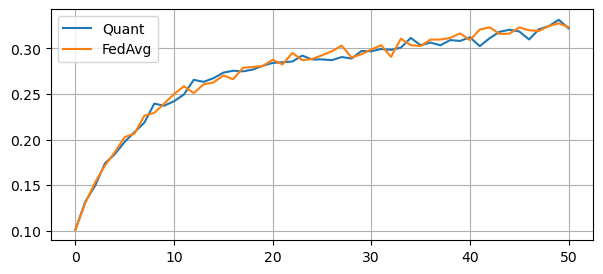

In [9]:
Bits = np.zeros([num_clients, num_global_iterations])
percentage = np.zeros([num_clients, num_global_iterations])
#-----------------------------------------------------
t_start=time.time()
dimension= 462410
Previous_diff_local_global_weight = np.zeros([num_clients, dimension]).T

for k in range(num_global_iterations):
    print(f"Global Iteration {k + 1}/{num_global_iterations}")

    # List to store client models for averaging
    client_models = []
    client_models_FedAvg = []
    

    for i in range(num_clients):
        print(f"Client {i + 1}/{num_clients}")
        x_local, y_local = client_data[i]

        # Create a copy of the global model for each client
        local_model = create_model()
        local_model.set_weights(global_weights)#global_model.get_weights())
        #----------------------- FedAvg benchmark--------------------------------
        local_model_FedAvg = create_model()
        local_model_FedAvg.set_weights(global_model_FedAvg.get_weights())
        local_model_FedAvg .compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        local_model_FedAvg .fit(x_local, y_local, epochs=local_epochs0, verbose=0)
        
            
        #----------------------------------------------------
        # Compile and train the local model
        local_model.compile(optimizer=optimizer,
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])
        
        local_model.fit(x_local, y_local, epochs=local_epochs , verbose=0)

        if k<= k_0:
            local_model.set_weights(local_model_FedAvg.get_weights())
#--------------------------------------------------- Quantization -----------------------------------------
        if k>k_0:
        # Quantize the local model weights
        #quantized_weights = [np.round(w * 127) / 127 for w in local_model.get_weights()]
            diff_local_global_weight = np.array(local_model.get_weights())#-np.array(global_weights) 
            local_weight_shape_0 = diff_local_global_weight.shape[0]
            quantized_diff_local_global_weight = diff_local_global_weight
            err = np.zeros([local_weight_shape_0 ,1])
            b_p = np.zeros([local_weight_shape_0 ,1])
            b_q =  np.zeros([local_weight_shape_0 ,1])
            x_previous = np.zeros([local_weight_shape_0 ,1])
            x_all_original = np.zeros([local_weight_shape_0 ,1])
            p10 = 0
            x_all = 0
            x = np.zeros([local_weight_shape_0,1])
            Quantized_diff_local_global_weight = []
            for h in range(local_weight_shape_0):
                x_position = 0
                if h==0:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(27*32,)
                    #Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
               ## quantized_diff_local_global_weight[h], tau, err[h], r = Quantization_NNs(bits,R,diff_local_global_weight[h])
                if h==2:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200*64,)
                
                if h in (1, 3, 5):
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(quantized_diff_local_global_weight[h].shape[0],)
                
                #if h==6:
                   # quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,1)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10*64,)
                
               #### x_previous[h] = np.max(abs(quantized_diff_local_global_weight[h]))
                ####x_position = np.where(np.abs(quantized_diff_local_global_weight[h]) == 
                ####                      max(np.abs(quantized_diff_local_global_weight[h])))
                ####x_temp=quantized_diff_local_global_weight[h] 
                ####x_all_original[h] = x_temp[x_position[0][0]] 
                #print(x[b[0][0]])
            
            #print(x_previous.T)
            ####x_all = np.max(x_previous)
           #### x_position_all = np.where(np.abs(x_previous) == max(np.abs(x_previous)))
            ####x_all_original1 = x_all_original[x_position_all[0][0]]
           #### print('x_all_original1:', x_all_original1)
            
           #### #print(x_previous.T)
            ####x_all = np.max(x_previous)
            #print('x_all:', x_all)
            
            for h in range(local_weight_shape_0):
                Quantized_diff_local_global_weight = np.concatenate((Quantized_diff_local_global_weight,quantized_diff_local_global_weight[h]))
           
            
            Quantized_diff_local_global_weight_for_me = Quantized_diff_local_global_weight
            print('max:',np.max(Quantized_diff_local_global_weight), '----min:',np.min(Quantized_diff_local_global_weight))
           
        # print('min:',np.min(Quantized_diff_local_global_weight))
        
            #nmax = 10000#min(2000*(2+k), 50000)
            #nmin = nmax
           # print( 'min of absolute value:',np.min(np.abs(Quantized_diff_local_global_weight)))
            #Quantized_diff_local_global_weight, max_model, min_model, err = adaptive_signQuant(Quantized_diff_local_global_weight, Quantized_diff_local_global_weight.shape[0], nmax,nmin)
            
            Quantized_diff_local_global_weight, y_q, err= LAQ(Quantized_diff_local_global_weight,  Previous_diff_local_global_weight[:,i], b_j)
 
            Bits[i,k] = (dimension )* (b_j)
            Quantized_diff_local_global_weight1 = Quantized_diff_local_global_weight
            Previous_diff_local_global_weight[:,i] = np.copy(Quantized_diff_local_global_weight)
           
            print('max error:', np.max(np.abs(err)))# - np.sum(Quantized_diff_local_global_weight1))
            #print('sum 1r:', np.sum(Quantized_diff_local_global_weight1))
            #print('max_model:', max_model)
            #print('min_model:', min_model)
            #print('max_model:', max_model, 'min_model:', min_model, 'x_min_me:', x_min_me)
            #percentage[i,k] = 100*(n_min+n_max)/462410
            #print('percentage %:', percentage[i,k] )
            #------------------ Update the local model with quantized weights:-----------------------------
            dim_h = 0
            for h in range(local_weight_shape_0):
                if h==0:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[0:27*32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(3, 3, 3, 32)
                    dim_h += 27*32
                    
                    
                if h==1:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+32]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(32,)
                    dim_h += 32
                if h==2: 
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+7200*64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(7200, 64)
                    dim_h+= 7200*64
                if h==3:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+64]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,)
                    dim_h += 64
            
                #if h==6:
                 #   quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    
                if h==4:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+640]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(64,10)
                    dim_h += 640
              
                if h==5:
                    quantized_diff_local_global_weight[h] = Quantized_diff_local_global_weight[dim_h: dim_h+10]
                    quantized_diff_local_global_weight[h] = quantized_diff_local_global_weight[h].reshape(10,)
                    dim_h += 10
            
            
            local_model.set_weights(quantized_diff_local_global_weight)# + np.array(global_weights))
        #else:
           # local_model.set_weights()
            
        # Add the trained and quantized local model to the list
        client_models.append(local_model)
        client_models_FedAvg.append(local_model_FedAvg)
        #B_q[:,k] += b_q
            
        #---------------------------FedAvg benchmark---------------------------------
    #print('nmax:', nmax)
    global_weights_FedAvg = np.mean([model0.get_weights() for model0 in client_models_FedAvg], axis=0)
    global_model_FedAvg.set_weights(global_weights_FedAvg)

#------------------------------------------------------------------------------------------------------------
    # Calculate the global model's new weights as the average of the client models
    if k <= k_0:
        global_model.set_weights(global_weights_FedAvg)
        global_weights = global_weights_FedAvg
    else:
        global_weights = np.mean([model.get_weights() for model in client_models], axis=0)
        global_model.set_weights(global_weights)
        #local_epochs = min(12, local_epochs + epoch_increase)
        #local_epochs += epoch_increase
        #local_epochs0 = local_epochs
        #local_epochs = max(1, local_epochs)
    
    if k == k_0:
        local_epochs += epoch_increase
        local_epochs0 = local_epochs
   # B_q[:,k] = b_q
#----------------------------------------------------------------------------
    # Evaluate the global model on the test data
    print('------------------------------------------------------------------------------------------------------')
    
    loss, accuracy = global_model.evaluate(x_test, y_test)
    print(f"Global Test loss: {loss:.4f}, Global Test accuracy: {accuracy:.4f}")
    global_acc_list.append(accuracy)
    global_loss_list.append(loss)
   # print('Lambda:',Lambda)
# The final global model is stored in 'global_model'
#-------------------------------------Evaluate the FedAvg global model on the test data----------------------
    print('------------------------------ ------FedAvg Benchmark------------------------------------------------')
    loss_FedAvg, accuracy_FedAvg = global_model_FedAvg.evaluate(x_test, y_test)
    print(f"_FedAvg Global Test loss: {loss_FedAvg:.4f}, _FedAvg Global Test accuracy: {accuracy_FedAvg:.4f}")
    print('------------------------------------------------------------------------------------------------------')
    global_acc_list_FedAvg.append(accuracy_FedAvg)
    global_loss_list_FedAvg.append(loss_FedAvg)
    #----------------
   # plt.figure(figsize=(7, 3))
   # plt.plot(global_acc_list)    
   # plt.plot(global_acc_list_FedAvg)
   # plt.legend(['Quant', 'FedAvg'])
   # plt.grid(True, which='major')   
    
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)            
            
            

simulation time: 14559.236819982529


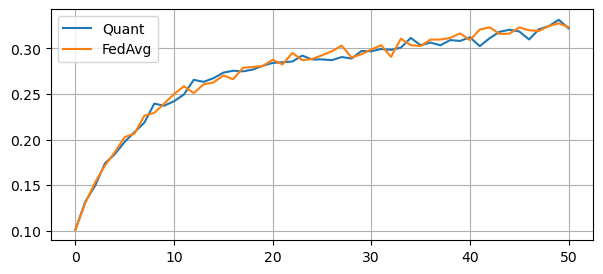

In [10]:
#K=40, L=5, b=10, SGD, non-iid LAQ
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 19079.14226937294


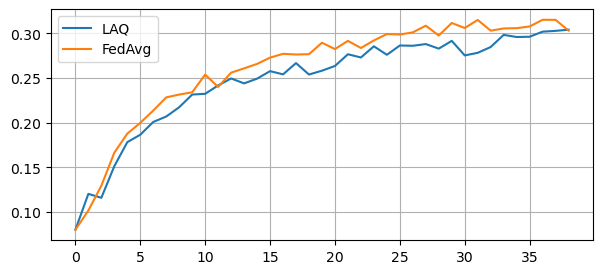

In [7]:
acc_q_temp = np.array(global_acc_list)
acc_fed_temp = np.array(global_acc_list_FedAvg)

acc_q = acc_q_temp[0:39]
acc_fed = acc_fed_temp[0:39]

#K=40, L=5, b=4, SGD, non-iid LAQ
plt.figure(figsize=(7, 3))
plt.plot(acc_q )    
plt.plot(acc_fed)
plt.legend(['LAQ', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

In [11]:
acc_q = np.array(global_acc_list)
acc_fed = np.array(global_acc_list_FedAvg)

# Base directory where you want to save the results
base_dir = 'C:/FedASi files'

# Prompt the user to input the folder name
#run_folder_name = input("Enter the folder name for this run: ")
run_folder_name = 'LAQ_Noniid_K40_L5_b10_T50'
run_folder_path = os.path.join(base_dir, run_folder_name)

# Create the directory if it doesn't exist
os.makedirs(run_folder_path, exist_ok=True)

# List of matrices to save and their respective filenames
matrices = {
    #'A_bar': A_bar,
    #'B_bar': B_bar,
    'Bits' : Bits,
    #'percentage': percentage,
    #'I_M': I_M,
    #'B_tilde': B_tilde,
    #'Lambda': Lambda,
    'acc_q' : acc_q,
    'acc_fed': acc_fed
    
    # Add more matrices here as needed
}

# Save each matrix to a .npy file in the specified folder
for name, matrix in matrices.items():
    file_name = os.path.join(run_folder_path, f'{name}.npy')
    np.save(file_name, matrix)
    print(f'{name} saved to {file_name}')


Bits saved to C:/FedASi files\LAQ_Noniid_K40_L5_b10_T50\Bits.npy
acc_q saved to C:/FedASi files\LAQ_Noniid_K40_L5_b10_T50\acc_q.npy
acc_fed saved to C:/FedASi files\LAQ_Noniid_K40_L5_b10_T50\acc_fed.npy


simulation time: 29001.526681423187


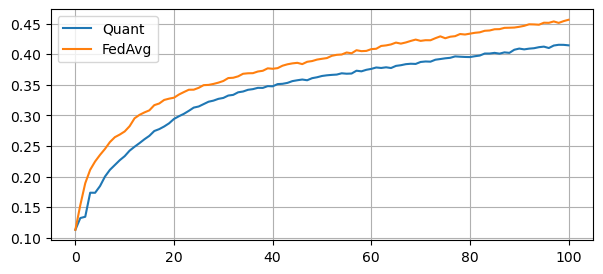

In [10]:
#K=40, L=5, b=4, SGD, iid
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 1393.7433576583862


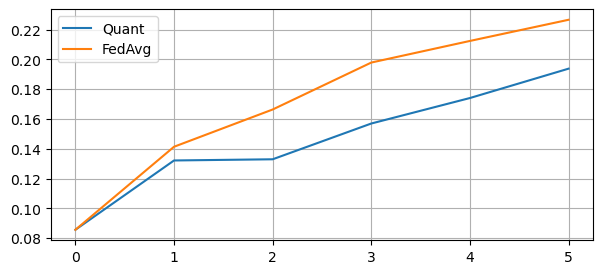

In [7]:
#K=40, L=5, b=4, SGD
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 25102.097023248672


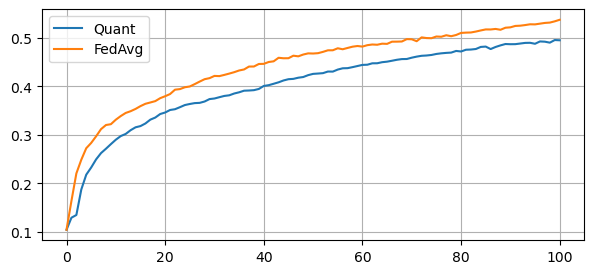

In [13]:
#K=20, L=5, b=4, SGD
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 12611.892499923706


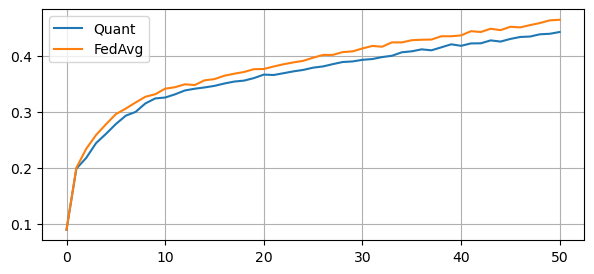

In [38]:
#K=20, L=5, b=5, SGD
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 705.4712464809418


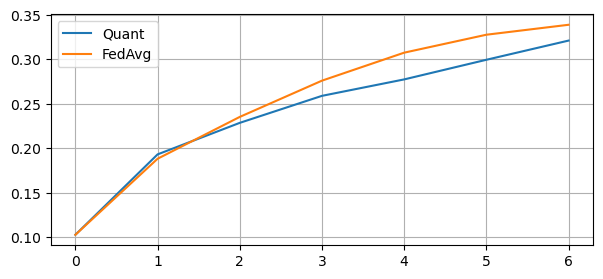

In [28]:
#K=5, L=2, b=5, SGD
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

simulation time: 620.1142735481262


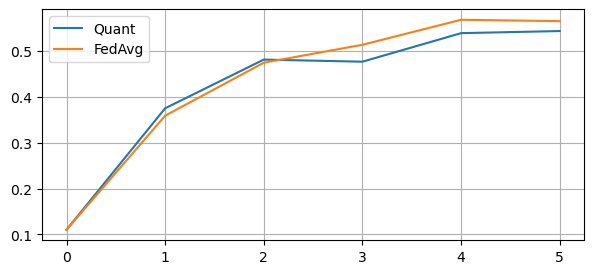

In [24]:
#K=5, L=2, b=5, AdaGrad which is not in the LAQ paper, so this was a wrong simulation:
plt.figure(figsize=(7, 3))
plt.plot(global_acc_list )    
plt.plot(global_acc_list_FedAvg)
plt.legend(['Quant', 'FedAvg'])
plt.grid(True, which='major')    
t_stop=time.time()            
print('simulation time:', t_stop- t_start)

In [2]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the input data x with b bits.

    Parameters:
    x (numpy array): Input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    x_min = np.min(x)
    x_max = np.max(x)
    
    # Quantization grid radius
    R = (x_max - x_min) / 2

    # Number of quantization levels
    L = 2 ** b
    
    # Quantization step size
    delta = (x_max - x_min) / (L - 1)
    
    # Uniform quantization
    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [x_min, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min
    
    return quantized

# Example usage
x =0.1* np.array([1.2, 3.5, 2.8, 4.0, 3.1])
b = 3  # Number of bits for quantization

# Quantize the values
quantized_values = uniform_quantization(x, b)
print("Original values:", x)
print("Quantized values:", quantized_values)


Original values: [0.12 0.35 0.28 0.4  0.31]
Quantized values: [0.12 0.36 0.28 0.4  0.32]


In [10]:
import numpy as np

def uniform_quantization(x, b):
    """
    Perform uniform quantization on the positive input data x with b bits.

    Parameters:
    x (numpy array): Positive input data to be quantized
    b (int): Number of bits for quantization

    Returns:
    numpy array: Quantized data
    """
    x_min = np.min(x)
    x_max = np.max(x)
    
    # Number of quantization levels
    L = 2 ** b

    # Quantization step size
    delta = (x_max ) / (L - 1)

    # Uniform quantization
    x_clipped = np.clip(x, x_min, x_max)  # Ensure values are within [x_min, x_max]
    quantized = np.round((x_clipped - x_min) / delta) * delta + x_min

    return quantized

# Example usage
x = np.array([1.2, 3.5, 2.8, 4.0, 3.1])
b = 3  # Number of bits for quantization

# Quantize the values
quantized_values = uniform_quantization(x, b)
print("Original values:", x)
print("Quantized values:", quantized_values)
print(x - quantized_values)

Original values: [1.2 3.5 2.8 4.  3.1]
Quantized values: [1.2        3.48571429 2.91428571 4.05714286 2.91428571]
[ 0.          0.01428571 -0.11428571 -0.05714286  0.18571429]


In [9]:
# Quantize the values
quantized_values = uniform_quantization(x, b)
print("Original values:", x)
print("Quantized values:", quantized_values)
print(x - quantized_values)

Original values: [1.2 3.5 2.8 4.  3.1]
Quantized values: [1.2 3.6 2.8 4.  3.2]
[ 0.  -0.1  0.   0.  -0.1]
